In [1]:
import os, sys, random, pandas as pd, numpy as np
from tqdm import tqdm
import torch


# set random seed
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
SEED = 10
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
sys.path.append('../')


# load package requirments
from VGFM.utils import  generate_steps, parser, _valid_criterions
from VGFM.plots import plot_comparision
from VGFM.train import pretrain, train
from VGFM.models import  FNet, ODEFunc2
from VGFM.constants import DATA_DIR
from VGFM.exp import setup_exp
from VGFM.eval import generate_plot_data
from torchdiffeq import odeint_adjoint as odeint

### Defining parameters and loading dataset

In [2]:
import torch.optim as optim

dim=5
f_net = FNet(in_out_dim=dim, hidden_dim=128, n_hiddens=3, activation='leakyrelu')

import sys

# Simulate the command-line arguments
sys.argv = [
    'VGFM Training',
    '-d', 'file',
    '-c', 'ot1',
    '-n', 'eb5_ho1',
    '--hold-one-out',
    '-ho', '1',
    '-e1', '2000',
    '-e2', '30',
    '-bs', '256',
    '-r', '0.01',
    '-rm', '5',
    '--norm_cost'
]

args = parser.parse_args()
opts = vars(args)

# Display the parsed arguments
print(opts)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


{'dataset': 'file', 'time_col': None, 'name': 'eb5_ho1', 'output_dir': 'd:\\NeurIPS_2025_VGFM\\VGFM\\results', 'criterion': 'ot1', 'sample_with_replacement': False, 'hold_one_out': True, 'hold_out': 1, 'apply_losses_in_time': True, 'learning_rate1': 0.001, 'epochs1': 2000, 'norm_cost': True, 'reg': 0.01, 'reg_m': 5.0, 'n_big_batches': 1, 'n_batch': 256, 'learning_rate2': 0.0001, 'epochs2': 30}


device(type='cpu')

In [3]:
df = pd.read_csv(DATA_DIR + '/eb_pca50.csv')
df=df.iloc[:,:dim+1]
 # make output dir
if not os.path.isdir(opts['output_dir']):
    os.makedirs(opts['output_dir'])
exp_dir, logger = setup_exp(opts['output_dir'], opts, opts['name'])
  # load dataset
logger.info(f'Loading dataset: '+opts['name'])


from sklearn.preprocessing import StandardScaler
import pandas as pd

cols_to_scale = [c for c in df.columns if c != "samples"]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
df = df_scaled


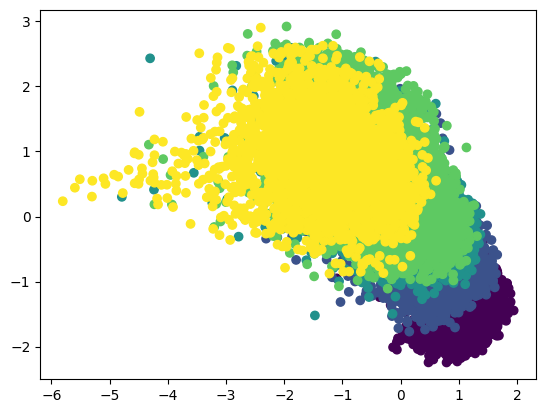

In [4]:
import matplotlib.pyplot as plt
plt.scatter(df.iloc[:,1],df.iloc[:,2],c=df.iloc[:,0])

In [5]:
args.hold_out

1

In [6]:
groups = sorted([g for g in df.samples.unique() if g != args.hold_out])
steps = generate_steps(groups)
optimizer = torch.optim.Adam(f_net.parameters())
opts['criterion']='ot1'
criterion =  _valid_criterions[opts['criterion']]()

# # logger.info(f'Extracting parameters')
use_cuda = torch.cuda.is_available()
# sample_with_replacement = opts['sample_with_replacement' ]
# apply_losses_in_time = opts['apply_losses_in_time']

    
local_losses = {f'{t0}:{t1}':[] for (t0, t1) in steps}
batch_losses = []
globe_losses = []

In [7]:
f_net=f_net.to(device)

In [8]:
initial_size=df[df['samples']==0].x1.shape[0]
initial_size

2381

In [9]:
sample_sizes = df.groupby('samples').size()
ref0 = sample_sizes / sample_sizes.iloc[0]  
relative_mass = torch.tensor(ref0.values) 
relative_mass

tensor([1.0000, 1.7484, 1.3767, 1.5393, 1.3994], dtype=torch.float64)

In [10]:
sample_size = (df[df['samples']==0.0].values.shape[0],)

### Training with $\mathcal{L}_{\rm VGFM}$

In [11]:
f_net, v_losses, g_losses, losses = pretrain(
    f_net,
    df,
    optimizer,
    n_epoch=args.epochs1,
    hold_out=args.hold_out,
    logger=logger,
    relative_mass=relative_mass,
    reg=args.reg,
    reg_m=[args.reg_m, np.inf],
    norm_cost=args.norm_cost,
    batch_size=args.n_batch
)


relative_mass tensor([1.0000, 1.7484, 1.3767, 1.5393, 1.3994], dtype=torch.float64)
t_train: [0, 2, 3, 4]


Begin flow and growth matching...: 100%|██████████| 2000/2000 [01:40<00:00, 19.94epoch/s, loss=0.221817, vloss=0.221784, gloss=0.000034]


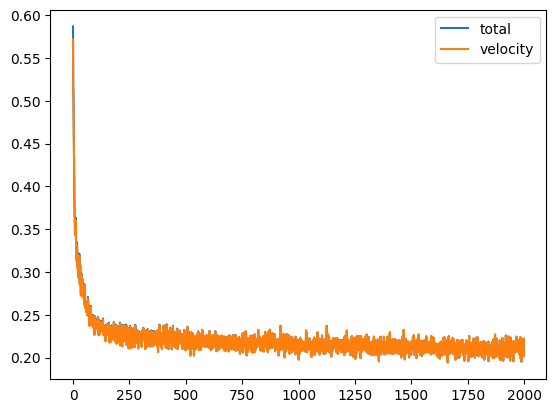

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses,label='total')
plt.plot(v_losses,label='velocity')
# plt.plot(g_losses,label='growth')
plt.legend()

In [13]:
torch.save(f_net.state_dict(), os.path.join(exp_dir+'/pretrain_best_model'))

In [14]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/pretrain_best_model'),map_location=torch.device('cpu')))
optimizer = torch.optim.Adam(f_net.parameters(),lr=args.learning_rate2)

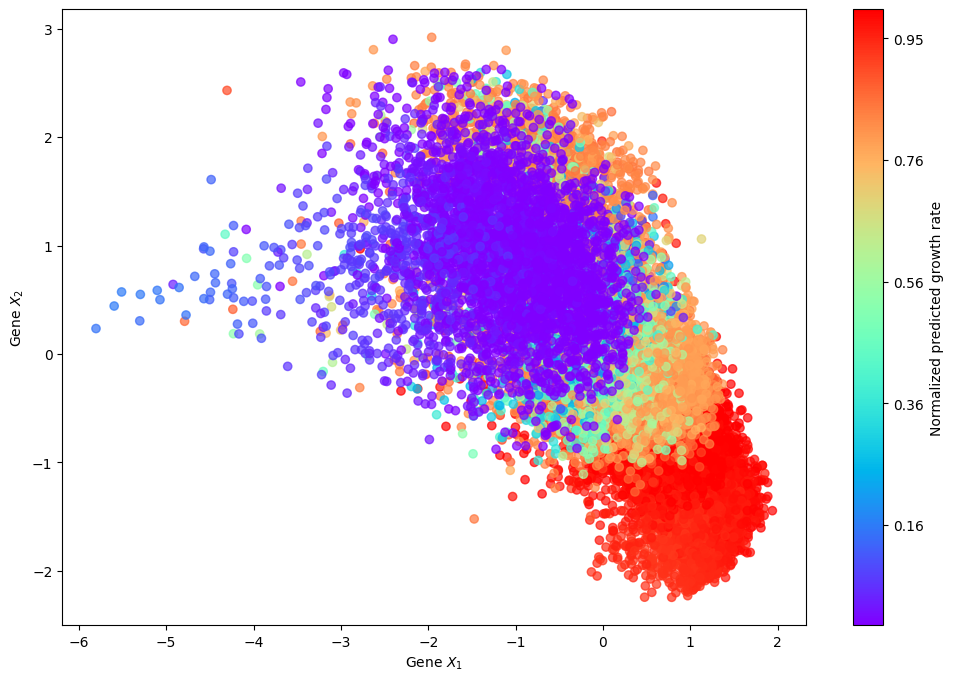

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 5

        column_names = [f'x{i}' for i in range(1, n + 1)]

        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 90)
    vmin_value = np.percentile(all_g_values, 10)
    
    norm = plt.Normalize(vmin=vmin_value, vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_pretrain.pdf')

In [16]:
# generate plot data
f_net.to('cpu')
generated, trajectories,_,_ = generate_plot_data(
    f_net, df, n_points=400, n_trajectories=50, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1., 2., 3., 4.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0404, 0.0808, 0.1212, 0.1616, 0.2020, 0.2424, 0.2828, 0.3232,
        0.3636, 0.4040, 0.4444, 0.4848, 0.5253, 0.5657, 0.6061, 0.6465, 0.6869,
        0.7273, 0.7677, 0.8081, 0.8485, 0.8889, 0.9293, 0.9697, 1.0101, 1.0505,
        1.0909, 1.1313, 1.1717, 1.2121, 1.2525, 1.2929, 1.3333, 1.3737, 1.4141,
        1.4545, 1.4949, 1.5354, 1.5758, 1.6162, 1.6566, 1.6970, 1.7374, 1.7778,
        1.8182, 1.8586, 1.8990, 1.9394, 1.9798, 2.0202, 2.0606, 2.1010, 2.1414,
        2.1818, 2.2222, 2.2626, 2.3030, 2.3434, 2.3838, 2.4242, 2.4646, 2.5051,
        2.5455, 2.5859, 2.6263, 2.6667, 2.7071, 2.7475, 2.7879, 2.8283, 2.8687,
        2.9091, 2.9495, 2.9899, 3.0303, 3.0707, 3.1111, 3.1515, 3.1919, 3.2323,
        3.2727, 3.3131, 3.3535, 3.3939, 3.4343, 3.4747, 3.5152, 3.5556, 3.5960,
        3.6364, 3.6768, 3.7172, 3.7576, 3.7980, 3.8384, 3.8788, 3.9192, 3.9596,
        4.0000])
<class 'torch.Tensor'>


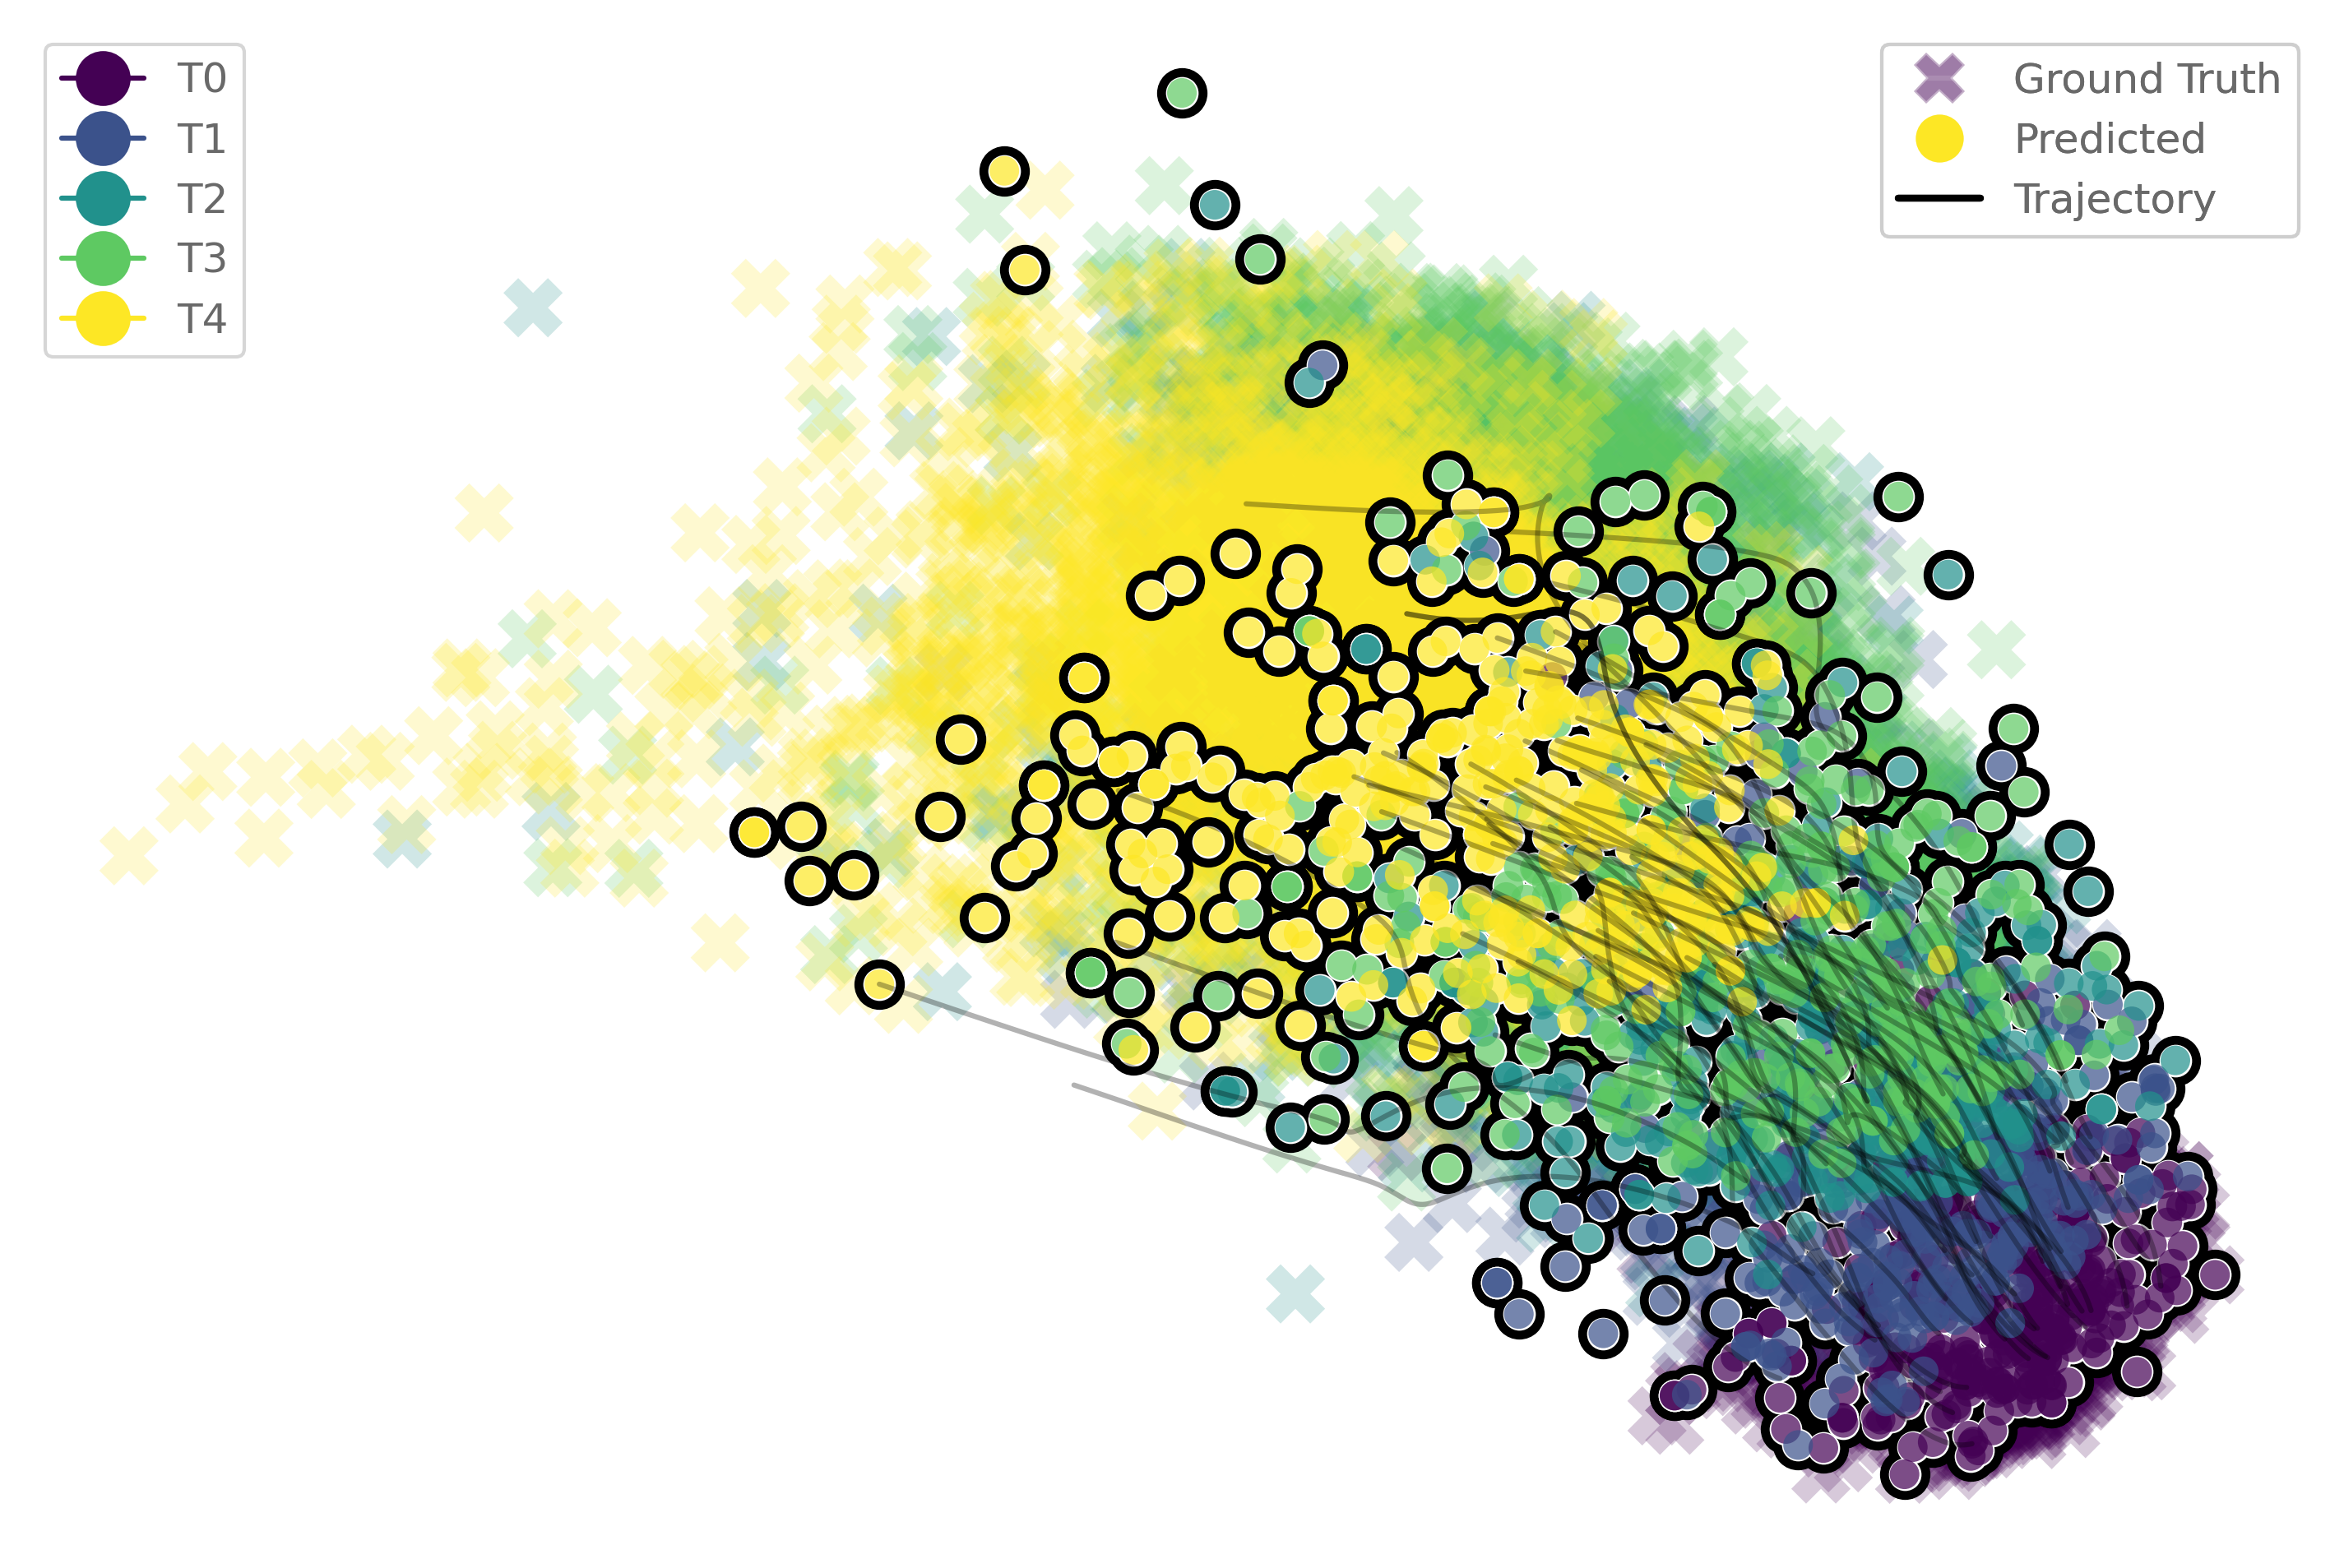

In [17]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_pretrain.png',
    x='x1', y='x2', is_3d=False
)

### Incorporating $\mathcal{L}_{\rm OT}$

Note: below, `relative_mass_now` is also displayed at the hold-out time points, which may cause a mismatch with `relative_mass_pred`. Please manually align the predicted and ground-truth time points when comparing them.

In [18]:
logger.info("Incorporating $L_{ot}$")

l_loss, b_loss, g_loss = train(
    f_net,
    df,
    groups,
    optimizer,
    args.epochs2,  # n_epoch
    criterion=criterion,
    use_cuda=use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=args.hold_one_out,
    hold_out=args.hold_out,
    sample_size=sample_size,
    relative_mass=relative_mass,
    initial_size=initial_size,
    sample_with_replacement=args.sample_with_replacement,
    logger=logger,
    device=device,
    best_model_path=exp_dir + "/best_model",
    stepsize=0.1,
)


for k, v in l_loss.items():
    local_losses[k].extend(v)

batch_losses.extend(b_loss)
globe_losses.extend(g_loss)


  0%|          | 0/30 [00:00<?, ?it/s]

[(0, 2), (2, 3), (3, 4)]
epoch_0_0:
relative_mass_pred:1.3600932359695435,relative_mass_now:1.7484250314993701
RME:0.22210377255741465
Otloss:1.04131
total loss:1.04131
epoch_0_1:
relative_mass_pred:1.5272705554962158,relative_mass_now:1.376732465350693
RME:0.10934447609410922
Otloss:1.02091
total loss:1.02091
epoch_0_2:
relative_mass_pred:1.4322960376739502,relative_mass_now:1.5392692146157076
RME:0.06949608029967927


d:\NeurIPS_2025_VGFM\VGFM\notebooks\..\VGFM\train.py:200: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  batch_loss = torch.Tensor(batch_loss).float()
  3%|▎         | 1/30 [00:03<01:50,  3.82s/it]

Otloss:1.0664
total loss:1.0664
New minimum otloss found: 1.0663998126983643. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_1_0:
relative_mass_pred:1.3584285974502563,relative_mass_now:1.7484250314993701
RME:0.22305585142227716
Otloss:0.94067
total loss:0.94067
epoch_1_1:
relative_mass_pred:1.5227161645889282,relative_mass_now:1.376732465350693
RME:0.10603635994089025
Otloss:0.895916
total loss:0.895916
epoch_1_2:
relative_mass_pred:1.425260305404663,relative_mass_now:1.5392692146157076
RME:0.07406690663888052


  7%|▋         | 2/30 [00:07<01:45,  3.76s/it]

Otloss:0.909498
total loss:0.909498
New minimum otloss found: 0.9094977378845215. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_2_0:
relative_mass_pred:1.356900930404663,relative_mass_now:1.7484250314993701
RME:0.22392959036908416
Otloss:0.872549
total loss:0.872549
epoch_2_1:
relative_mass_pred:1.519116997718811,relative_mass_now:1.376732465350693
RME:0.10342207796476181
Otloss:0.812927
total loss:0.812927
epoch_2_2:
relative_mass_pred:1.4177453517913818,relative_mass_now:1.5392692146157076
RME:0.07894906340647197


 10%|█         | 3/30 [00:11<01:40,  3.73s/it]

Otloss:0.789003
total loss:0.789003
New minimum otloss found: 0.7890026569366455. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_3_0:
relative_mass_pred:1.3554613590240479,relative_mass_now:1.7484250314993701
RME:0.22475294358965703
Otloss:0.820347
total loss:0.820347
epoch_3_1:
relative_mass_pred:1.515995740890503,relative_mass_now:1.376732465350693
RME:0.10115492954859293
Otloss:0.76068
total loss:0.76068
epoch_3_2:
relative_mass_pred:1.4102911949157715,relative_mass_now:1.5392692146157076
RME:0.08379172303016316


 13%|█▎        | 4/30 [00:14<01:35,  3.68s/it]

Otloss:0.720696
total loss:0.720696
New minimum otloss found: 0.7206961512565613. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_4_0:
relative_mass_pred:1.3541796207427979,relative_mass_now:1.7484250314993701
RME:0.22548602522493358
Otloss:0.780109
total loss:0.780109
epoch_4_1:
relative_mass_pred:1.5132880210876465,relative_mass_now:1.376732465350693
RME:0.0991881568668964
Otloss:0.734841
total loss:0.734841
epoch_4_2:
relative_mass_pred:1.4036529064178467,relative_mass_now:1.5392692146157076
RME:0.08810434647178908


 17%|█▋        | 5/30 [00:18<01:31,  3.65s/it]

Otloss:0.71697
total loss:0.71697
New minimum otloss found: 0.7169697880744934. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_5_0:
relative_mass_pred:1.3531287908554077,relative_mass_now:1.7484250314993701
RME:0.22608704034909308
Otloss:0.749528
total loss:0.749528
epoch_5_1:
relative_mass_pred:1.5110877752304077,relative_mass_now:1.376732465350693
RME:0.09758999170945726
Otloss:0.726039
total loss:0.726039
epoch_5_2:
relative_mass_pred:1.3984615802764893,relative_mass_now:1.5392692146157076
RME:0.09147693788858909


 20%|██        | 6/30 [00:22<01:27,  3.65s/it]

Otloss:0.757402
total loss:0.757402
[(0, 2), (2, 3), (3, 4)]
epoch_6_0:
relative_mass_pred:1.3523447513580322,relative_mass_now:1.7484250314993701
RME:0.22653546649448125
Otloss:0.726652
total loss:0.726652
epoch_6_1:
relative_mass_pred:1.5094819068908691,relative_mass_now:1.376732465350693
RME:0.09642355714068321
Otloss:0.722655
total loss:0.722655
epoch_6_2:
relative_mass_pred:1.3949289321899414,relative_mass_now:1.5392692146157076
RME:0.0937719542853341


 23%|██▎       | 7/30 [00:25<01:24,  3.67s/it]

Otloss:0.797069
total loss:0.797069
[(0, 2), (2, 3), (3, 4)]
epoch_7_0:
relative_mass_pred:1.3518221378326416,relative_mass_now:1.7484250314993701
RME:0.22683437180410293
Otloss:0.709669
total loss:0.709669
epoch_7_1:
relative_mass_pred:1.5085147619247437,relative_mass_now:1.376732465350693
RME:0.09572106410702098
Otloss:0.715989
total loss:0.715989
epoch_7_2:
relative_mass_pred:1.3929075002670288,relative_mass_now:1.5392692146157076
RME:0.09508519559732724


 27%|██▋       | 8/30 [00:29<01:20,  3.67s/it]

Otloss:0.805317
total loss:0.805317
[(0, 2), (2, 3), (3, 4)]
epoch_8_0:
relative_mass_pred:1.3515090942382812,relative_mass_now:1.7484250314993701
RME:0.22701341499367103
Otloss:0.69648
total loss:0.69648
epoch_8_1:
relative_mass_pred:1.5080807209014893,relative_mass_now:1.376732465350693
RME:0.09540579513924528
Otloss:0.702972
total loss:0.702972
epoch_8_2:
relative_mass_pred:1.3920578956604004,relative_mass_now:1.5392692146157076
RME:0.09563714882198815


 30%|███       | 9/30 [00:33<01:16,  3.66s/it]

Otloss:0.778804
total loss:0.778804
[(0, 2), (2, 3), (3, 4)]
epoch_9_0:
relative_mass_pred:1.3513388633728027,relative_mass_now:1.7484250314993701
RME:0.2271107773983562
Otloss:0.685291
total loss:0.685291
epoch_9_1:
relative_mass_pred:1.5080299377441406,relative_mass_now:1.376732465350693
RME:0.09536890841024984
Otloss:0.684727
total loss:0.684727
epoch_9_2:
relative_mass_pred:1.3920395374298096,relative_mass_now:1.5392692146157076
RME:0.09564907541053842


 33%|███▎      | 10/30 [00:36<01:13,  3.66s/it]

Otloss:0.730905
total loss:0.730905
[(0, 2), (2, 3), (3, 4)]
epoch_10_0:
relative_mass_pred:1.3512580394744873,relative_mass_now:1.7484250314993701
RME:0.22715700408629497
Otloss:0.675104
total loss:0.675104
epoch_10_1:
relative_mass_pred:1.5082159042358398,relative_mass_now:1.376732465350693
RME:0.0955039865727684
Otloss:0.66431
total loss:0.66431
epoch_10_2:
relative_mass_pred:1.3925278186798096,relative_mass_now:1.5392692146157076
RME:0.0953318591332533


 37%|███▋      | 11/30 [00:40<01:09,  3.64s/it]

Otloss:0.678197
total loss:0.678197
New minimum otloss found: 0.6781966686248779. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_11_0:
relative_mass_pred:1.3512333631515503,relative_mass_now:1.7484250314993701
RME:0.22717111754411698
Otloss:0.665822
total loss:0.665822
epoch_11_1:
relative_mass_pred:1.5085209608078003,relative_mass_now:1.376732465350693
RME:0.09572556671243826
Otloss:0.64483
total loss:0.64483
epoch_11_2:
relative_mass_pred:1.3932757377624512,relative_mass_now:1.5392692146157076
RME:0.09484596681790004


 40%|████      | 12/30 [00:43<01:05,  3.61s/it]

Otloss:0.633804
total loss:0.633804
New minimum otloss found: 0.6338039636611938. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_12_0:
relative_mass_pred:1.3512475490570068,relative_mass_now:1.7484250314993701
RME:0.22716300401039322
Otloss:0.657581
total loss:0.657581
epoch_12_1:
relative_mass_pred:1.5088696479797363,relative_mass_now:1.376732465350693
RME:0.09597883826716057
Otloss:0.627827
total loss:0.627827
epoch_12_2:
relative_mass_pred:1.3940948247909546,relative_mass_now:1.5392692146157076
RME:0.09431383961056945


 43%|████▎     | 13/30 [00:47<01:00,  3.57s/it]

Otloss:0.603951
total loss:0.603951
New minimum otloss found: 0.6039507389068604. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_13_0:
relative_mass_pred:1.351285457611084,relative_mass_now:1.7484250314993701
RME:0.22714132246649274
Otloss:0.650125
total loss:0.650125
epoch_13_1:
relative_mass_pred:1.509203553199768,relative_mass_now:1.376732465350693
RME:0.09622137283973395
Otloss:0.613397
total loss:0.613397
epoch_13_2:
relative_mass_pred:1.3948659896850586,relative_mass_now:1.5392692146157076
RME:0.09381284544607787


 47%|████▋     | 14/30 [00:50<00:56,  3.54s/it]

Otloss:0.588237
total loss:0.588237
New minimum otloss found: 0.588236927986145. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_14_0:
relative_mass_pred:1.3513201475143433,relative_mass_now:1.7484250314993701
RME:0.22712148180839511
Otloss:0.643021
total loss:0.643021
epoch_14_1:
relative_mass_pred:1.5094636678695679,relative_mass_now:1.376732465350693
RME:0.0964103090901285
Otloss:0.601224
total loss:0.601224
epoch_14_2:
relative_mass_pred:1.395478367805481,relative_mass_now:1.5392692146157076
RME:0.09341500852800812


 50%|█████     | 15/30 [00:54<00:52,  3.52s/it]

Otloss:0.582698
total loss:0.582698
New minimum otloss found: 0.5826981067657471. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_15_0:
relative_mass_pred:1.3513203859329224,relative_mass_now:1.7484250314993701
RME:0.2271213454464838
Otloss:0.635987
total loss:0.635987
epoch_15_1:
relative_mass_pred:1.5096063613891602,relative_mass_now:1.376732465350693
RME:0.09651395560329178
Otloss:0.591308
total loss:0.591308
epoch_15_2:
relative_mass_pred:1.3958569765090942,relative_mass_now:1.5392692146157076
RME:0.09316904200050383


 53%|█████▎    | 16/30 [00:57<00:48,  3.48s/it]

Otloss:0.581281
total loss:0.581281
New minimum otloss found: 0.5812808871269226. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_16_0:
relative_mass_pred:1.351261019706726,relative_mass_now:1.7484250314993701
RME:0.2271552995624034
Otloss:0.628915
total loss:0.628915
epoch_16_1:
relative_mass_pred:1.50961172580719,relative_mass_now:1.376732465350693
RME:0.09651785208874905
Otloss:0.58361
total loss:0.58361
epoch_16_2:
relative_mass_pred:1.3959507942199707,relative_mass_now:1.5392692146157076
RME:0.09310809248628914


 57%|█████▋    | 17/30 [01:01<00:44,  3.46s/it]

Otloss:0.579695
total loss:0.579695
New minimum otloss found: 0.5796949863433838. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_17_0:
relative_mass_pred:1.3511357307434082,relative_mass_now:1.7484250314993701
RME:0.22722695774680404
Otloss:0.621855
total loss:0.621855
epoch_17_1:
relative_mass_pred:1.5094926357269287,relative_mass_now:1.376732465350693
RME:0.09643135011159774
Otloss:0.577772
total loss:0.577772
epoch_17_2:
relative_mass_pred:1.3957635164260864,relative_mass_now:1.5392692146157076
RME:0.09322975917857794


 60%|██████    | 18/30 [01:04<00:41,  3.43s/it]

Otloss:0.576667
total loss:0.576667
New minimum otloss found: 0.5766666531562805. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_18_0:
relative_mass_pred:1.350961446762085,relative_mass_now:1.7484250314993701
RME:0.22732663830398173
Otloss:0.614985
total loss:0.614985
epoch_18_1:
relative_mass_pred:1.5092912912368774,relative_mass_now:1.376732465350693
RME:0.09628510202410169
Otloss:0.573229
total loss:0.573229
epoch_18_2:
relative_mass_pred:1.3953447341918945,relative_mass_now:1.5392692146157076
RME:0.09350182479920847


 63%|██████▎   | 19/30 [01:07<00:37,  3.41s/it]

Otloss:0.572508
total loss:0.572508
New minimum otloss found: 0.5725084543228149. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_19_0:
relative_mass_pred:1.3507733345031738,relative_mass_now:1.7484250314993701
RME:0.22743422785201617
Otloss:0.608497
total loss:0.608497
epoch_19_1:
relative_mass_pred:1.5090632438659668,relative_mass_now:1.376732465350693
RME:0.09611945809788501
Otloss:0.569159
total loss:0.569159
epoch_19_2:
relative_mass_pred:1.3947839736938477,relative_mass_now:1.5392692146157076
RME:0.09386612786765311


 67%|██████▋   | 20/30 [01:11<00:33,  3.40s/it]

Otloss:0.568031
total loss:0.568031
New minimum otloss found: 0.568030595779419. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_20_0:
relative_mass_pred:1.3506083488464355,relative_mass_now:1.7484250314993701
RME:0.22752859029465222
Otloss:0.602451
total loss:0.602451
epoch_20_1:
relative_mass_pred:1.5088579654693604,relative_mass_now:1.376732465350693
RME:0.0959703525877203
Otloss:0.564778
total loss:0.564778
epoch_20_2:
relative_mass_pred:1.3942017555236816,relative_mass_now:1.5392692146157076
RME:0.09424437110453314


 70%|███████   | 21/30 [01:14<00:30,  3.38s/it]

Otloss:0.564131
total loss:0.564131
New minimum otloss found: 0.5641310811042786. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_21_0:
relative_mass_pred:1.3504866361618042,relative_mass_now:1.7484250314993701
RME:0.227598203050383
Otloss:0.596779
total loss:0.596779
epoch_21_1:
relative_mass_pred:1.5087039470672607,relative_mass_now:1.376732465350693
RME:0.0958584801608139
Otloss:0.559788
total loss:0.559788
epoch_21_2:
relative_mass_pred:1.3937160968780518,relative_mass_now:1.5392692146157076
RME:0.09455988358345394


 73%|███████▎  | 22/30 [01:17<00:26,  3.37s/it]

Otloss:0.561283
total loss:0.561283
New minimum otloss found: 0.5612825751304626. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_22_0:
relative_mass_pred:1.3504078388214111,relative_mass_now:1.7484250314993701
RME:0.2276432706620755
Otloss:0.591409
total loss:0.591409
epoch_22_1:
relative_mass_pred:1.5086066722869873,relative_mass_now:1.376732465350693
RME:0.09578782389118881
Otloss:0.554351
total loss:0.554351
epoch_22_2:
relative_mass_pred:1.3934048414230347,relative_mass_now:1.5392692146157076
RME:0.09476209347114717


 77%|███████▋  | 23/30 [01:21<00:23,  3.37s/it]

Otloss:0.559134
total loss:0.559134
New minimum otloss found: 0.5591344833374023. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_23_0:
relative_mass_pred:1.3503587245941162,relative_mass_now:1.7484250314993701
RME:0.2276713612158082
Otloss:0.586282
total loss:0.586282
epoch_23_1:
relative_mass_pred:1.5085581541061401,relative_mass_now:1.376732465350693
RME:0.09575258234494198
Otloss:0.548873
total loss:0.548873
epoch_23_2:
relative_mass_pred:1.393289566040039,relative_mass_now:1.5392692146157076
RME:0.09483698315379725


 80%|████████  | 24/30 [01:24<00:20,  3.35s/it]

Otloss:0.557116
total loss:0.557116
New minimum otloss found: 0.5571157336235046. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_24_0:
relative_mass_pred:1.3503248691558838,relative_mass_now:1.7484250314993701
RME:0.22769072460721618
Otloss:0.581349
total loss:0.581349
epoch_24_1:
relative_mass_pred:1.508543848991394,relative_mass_now:1.376732465350693
RME:0.09574219171705593
Otloss:0.543694
total loss:0.543694
epoch_24_2:
relative_mass_pred:1.3933384418487549,relative_mass_now:1.5392692146157076
RME:0.09480523054791666


 83%|████████▎ | 25/30 [01:27<00:16,  3.33s/it]

Otloss:0.555322
total loss:0.555322
New minimum otloss found: 0.5553224086761475. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_25_0:
relative_mass_pred:1.3503012657165527,relative_mass_now:1.7484250314993701
RME:0.22770422443643723
Otloss:0.576598
total loss:0.576598
epoch_25_1:
relative_mass_pred:1.5085564851760864,relative_mass_now:1.376732465350693
RME:0.09575137010502194
Otloss:0.539024
total loss:0.539024
epoch_25_2:
relative_mass_pred:1.3934972286224365,relative_mass_now:1.5392692146157076
RME:0.09470207330149483


 87%|████████▋ | 26/30 [01:31<00:13,  3.32s/it]

Otloss:0.55416
total loss:0.55416
New minimum otloss found: 0.5541595220565796. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_26_0:
relative_mass_pred:1.3502939939498901,relative_mass_now:1.7484250314993701
RME:0.2277083834747326
Otloss:0.57204
total loss:0.57204
epoch_26_1:
relative_mass_pred:1.5085939168930054,relative_mass_now:1.376732465350693
RME:0.09577855891465709
Otloss:0.534644
total loss:0.534644
epoch_26_2:
relative_mass_pred:1.3936997652053833,relative_mass_now:1.5392692146157076
RME:0.09457049360054087


 90%|█████████ | 27/30 [01:34<00:09,  3.31s/it]

Otloss:0.553569
total loss:0.553569
New minimum otloss found: 0.5535687208175659. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_27_0:
relative_mass_pred:1.350306749343872,relative_mass_now:1.7484250314993701
RME:0.22770108811247677
Otloss:0.567646
total loss:0.567646
epoch_27_1:
relative_mass_pred:1.5086500644683838,relative_mass_now:1.376732465350693
RME:0.09581934212910981
Otloss:0.530307
total loss:0.530307
epoch_27_2:
relative_mass_pred:1.3938920497894287,relative_mass_now:1.5392692146157076
RME:0.0944455742022838


 93%|█████████▎| 28/30 [01:37<00:06,  3.29s/it]

Otloss:0.55315
total loss:0.55315
New minimum otloss found: 0.5531501173973083. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_28_0:
relative_mass_pred:1.3503310680389404,relative_mass_now:1.7484250314993701
RME:0.22768717919752174
Otloss:0.563396
total loss:0.563396
epoch_28_1:
relative_mass_pred:1.508709192276001,relative_mass_now:1.376732465350693
RME:0.09586229005770545
Otloss:0.526091
total loss:0.526091
epoch_28_2:
relative_mass_pred:1.3940417766571045,relative_mass_now:1.5392692146157076
RME:0.09434830280475692


 97%|█████████▋| 29/30 [01:40<00:03,  3.29s/it]

Otloss:0.552625
total loss:0.552625
New minimum otloss found: 0.5526251196861267. Model saved.
[(0, 2), (2, 3), (3, 4)]
epoch_29_0:
relative_mass_pred:1.3503503799438477,relative_mass_now:1.7484250314993701
RME:0.22767613388270452
Otloss:0.559287
total loss:0.559287
epoch_29_1:
relative_mass_pred:1.5087499618530273,relative_mass_now:1.376732465350693
RME:0.09589190334718067
Otloss:0.522356
total loss:0.522356
epoch_29_2:
relative_mass_pred:1.3941391706466675,relative_mass_now:1.5392692146157076
RME:0.09428502992913633


100%|██████████| 30/30 [01:44<00:00,  3.47s/it]

Otloss:0.551924
total loss:0.551924
New minimum otloss found: 0.5519237518310547. Model saved.


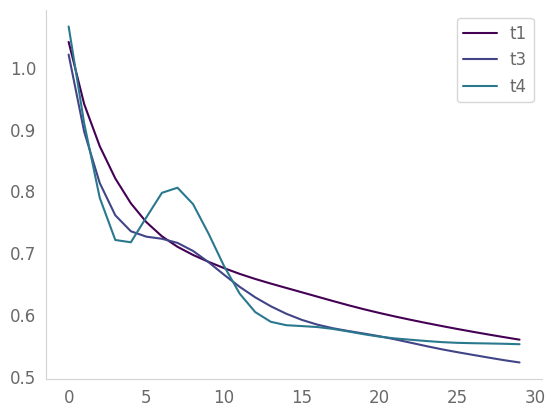

In [20]:
import os
import matplotlib.pyplot as plt

# 假设你已有变量：l_loss 和 exp_dir
plt.plot(l_loss['0:2'], label='t1')
plt.plot(l_loss['2:3'], label='t3')
plt.plot(l_loss['3:4'], label='t4')
plt.legend()

# 拼接保存路径
save_path = os.path.join(exp_dir, 'emd_train_each_tp.png')
plt.savefig(save_path)

### Test

In [36]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/best_model'),map_location=torch.device('cpu')))

<All keys matched successfully>

In [22]:
groups =[0,1,2,3,4]

For simplicity, we present the prediction results using function `train` by setting `epoch=1`, `hold_one_out=False` and `hold_out=-1`, one just need to focus on the **hold-out** time points.  
For example, if the hold-out time point is **n**, then the **OT loss of `epoch0_{n-1}`** corresponds to the **EMD at the hold-out time point**.


In [23]:
logger.info("Testing on held out time point")
l_loss, b_loss, g_loss = train(
    f_net, df, groups, optimizer, 1, 
    criterion = criterion, use_cuda = use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=False, hold_out=-1, 
    sample_size = sample_size,relative_mass=relative_mass,initial_size=initial_size,
    sample_with_replacement = args.sample_with_replacement, logger=logger, device=device, best_model_path=exp_dir+'/test_model',stepsize=0.1
)

  0%|          | 0/1 [00:00<?, ?it/s]

epoch_0_0:
relative_mass_pred:1.1667234897613525,relative_mass_now:1.7484250314993701
RME:0.33270030527941863
Otloss:0.60694
total loss:0.60694
epoch_0_1:
relative_mass_pred:1.3503309488296509,relative_mass_now:1.376732465350693
RME:0.019176940462660507
Otloss:0.554647
total loss:0.554647
epoch_0_2:
relative_mass_pred:1.5087246894836426,relative_mass_now:1.5392692146157076
RME:0.019843523694255644
Otloss:0.51865
total loss:0.51865
epoch_0_3:
relative_mass_pred:1.3940190076828003,relative_mass_now:1.3994120117597648
RME:0.0038537643179029214


100%|██████████| 1/1 [00:04<00:00,  4.67s/it]

Otloss:0.55055
total loss:0.55055
New minimum otloss found: 0.5505498647689819. Model saved.


In [37]:
# generate plot data
f_net.to('cpu')
generated, trajectories,generated_weights,trajectories_weights = generate_plot_data(
    f_net, df, n_points=400, n_trajectories=50, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1., 2., 3., 4.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0404, 0.0808, 0.1212, 0.1616, 0.2020, 0.2424, 0.2828, 0.3232,
        0.3636, 0.4040, 0.4444, 0.4848, 0.5253, 0.5657, 0.6061, 0.6465, 0.6869,
        0.7273, 0.7677, 0.8081, 0.8485, 0.8889, 0.9293, 0.9697, 1.0101, 1.0505,
        1.0909, 1.1313, 1.1717, 1.2121, 1.2525, 1.2929, 1.3333, 1.3737, 1.4141,
        1.4545, 1.4949, 1.5354, 1.5758, 1.6162, 1.6566, 1.6970, 1.7374, 1.7778,
        1.8182, 1.8586, 1.8990, 1.9394, 1.9798, 2.0202, 2.0606, 2.1010, 2.1414,
        2.1818, 2.2222, 2.2626, 2.3030, 2.3434, 2.3838, 2.4242, 2.4646, 2.5051,
        2.5455, 2.5859, 2.6263, 2.6667, 2.7071, 2.7475, 2.7879, 2.8283, 2.8687,
        2.9091, 2.9495, 2.9899, 3.0303, 3.0707, 3.1111, 3.1515, 3.1919, 3.2323,
        3.2727, 3.3131, 3.3535, 3.3939, 3.4343, 3.4747, 3.5152, 3.5556, 3.5960,
        3.6364, 3.6768, 3.7172, 3.7576, 3.7980, 3.8384, 3.8788, 3.9192, 3.9596,
        4.0000])
<class 'torch.Tensor'>


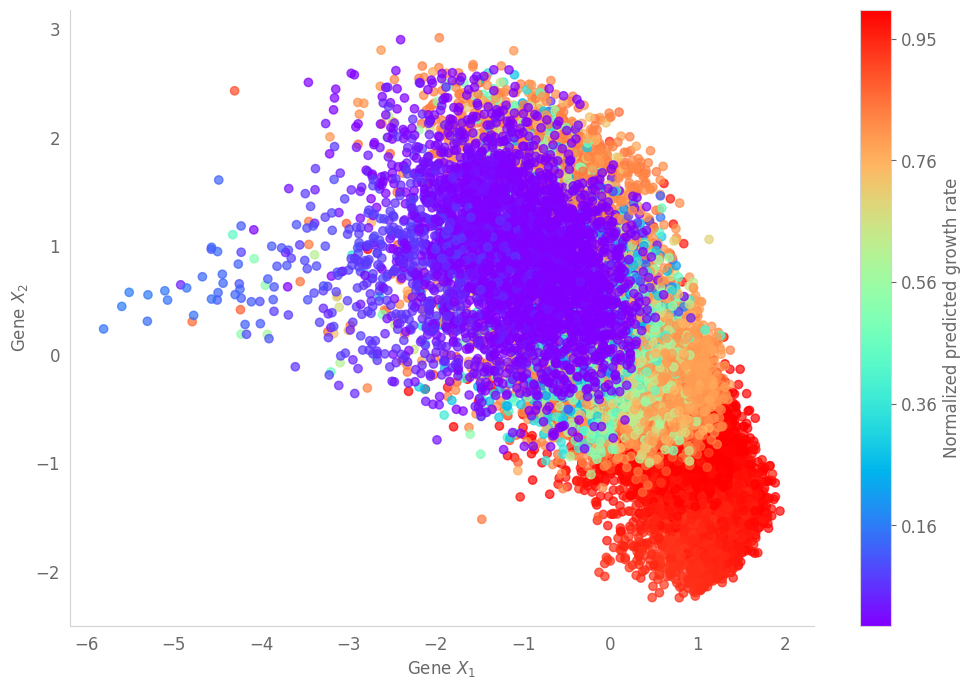

In [38]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 5

        column_names = [f'x{i}' for i in range(1, n + 1)]

        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g= f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 90)
    vmin_value = np.percentile(all_g_values, 10)
    
    norm = plt.Normalize(vmin=vmin_value, vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_final.pdf')

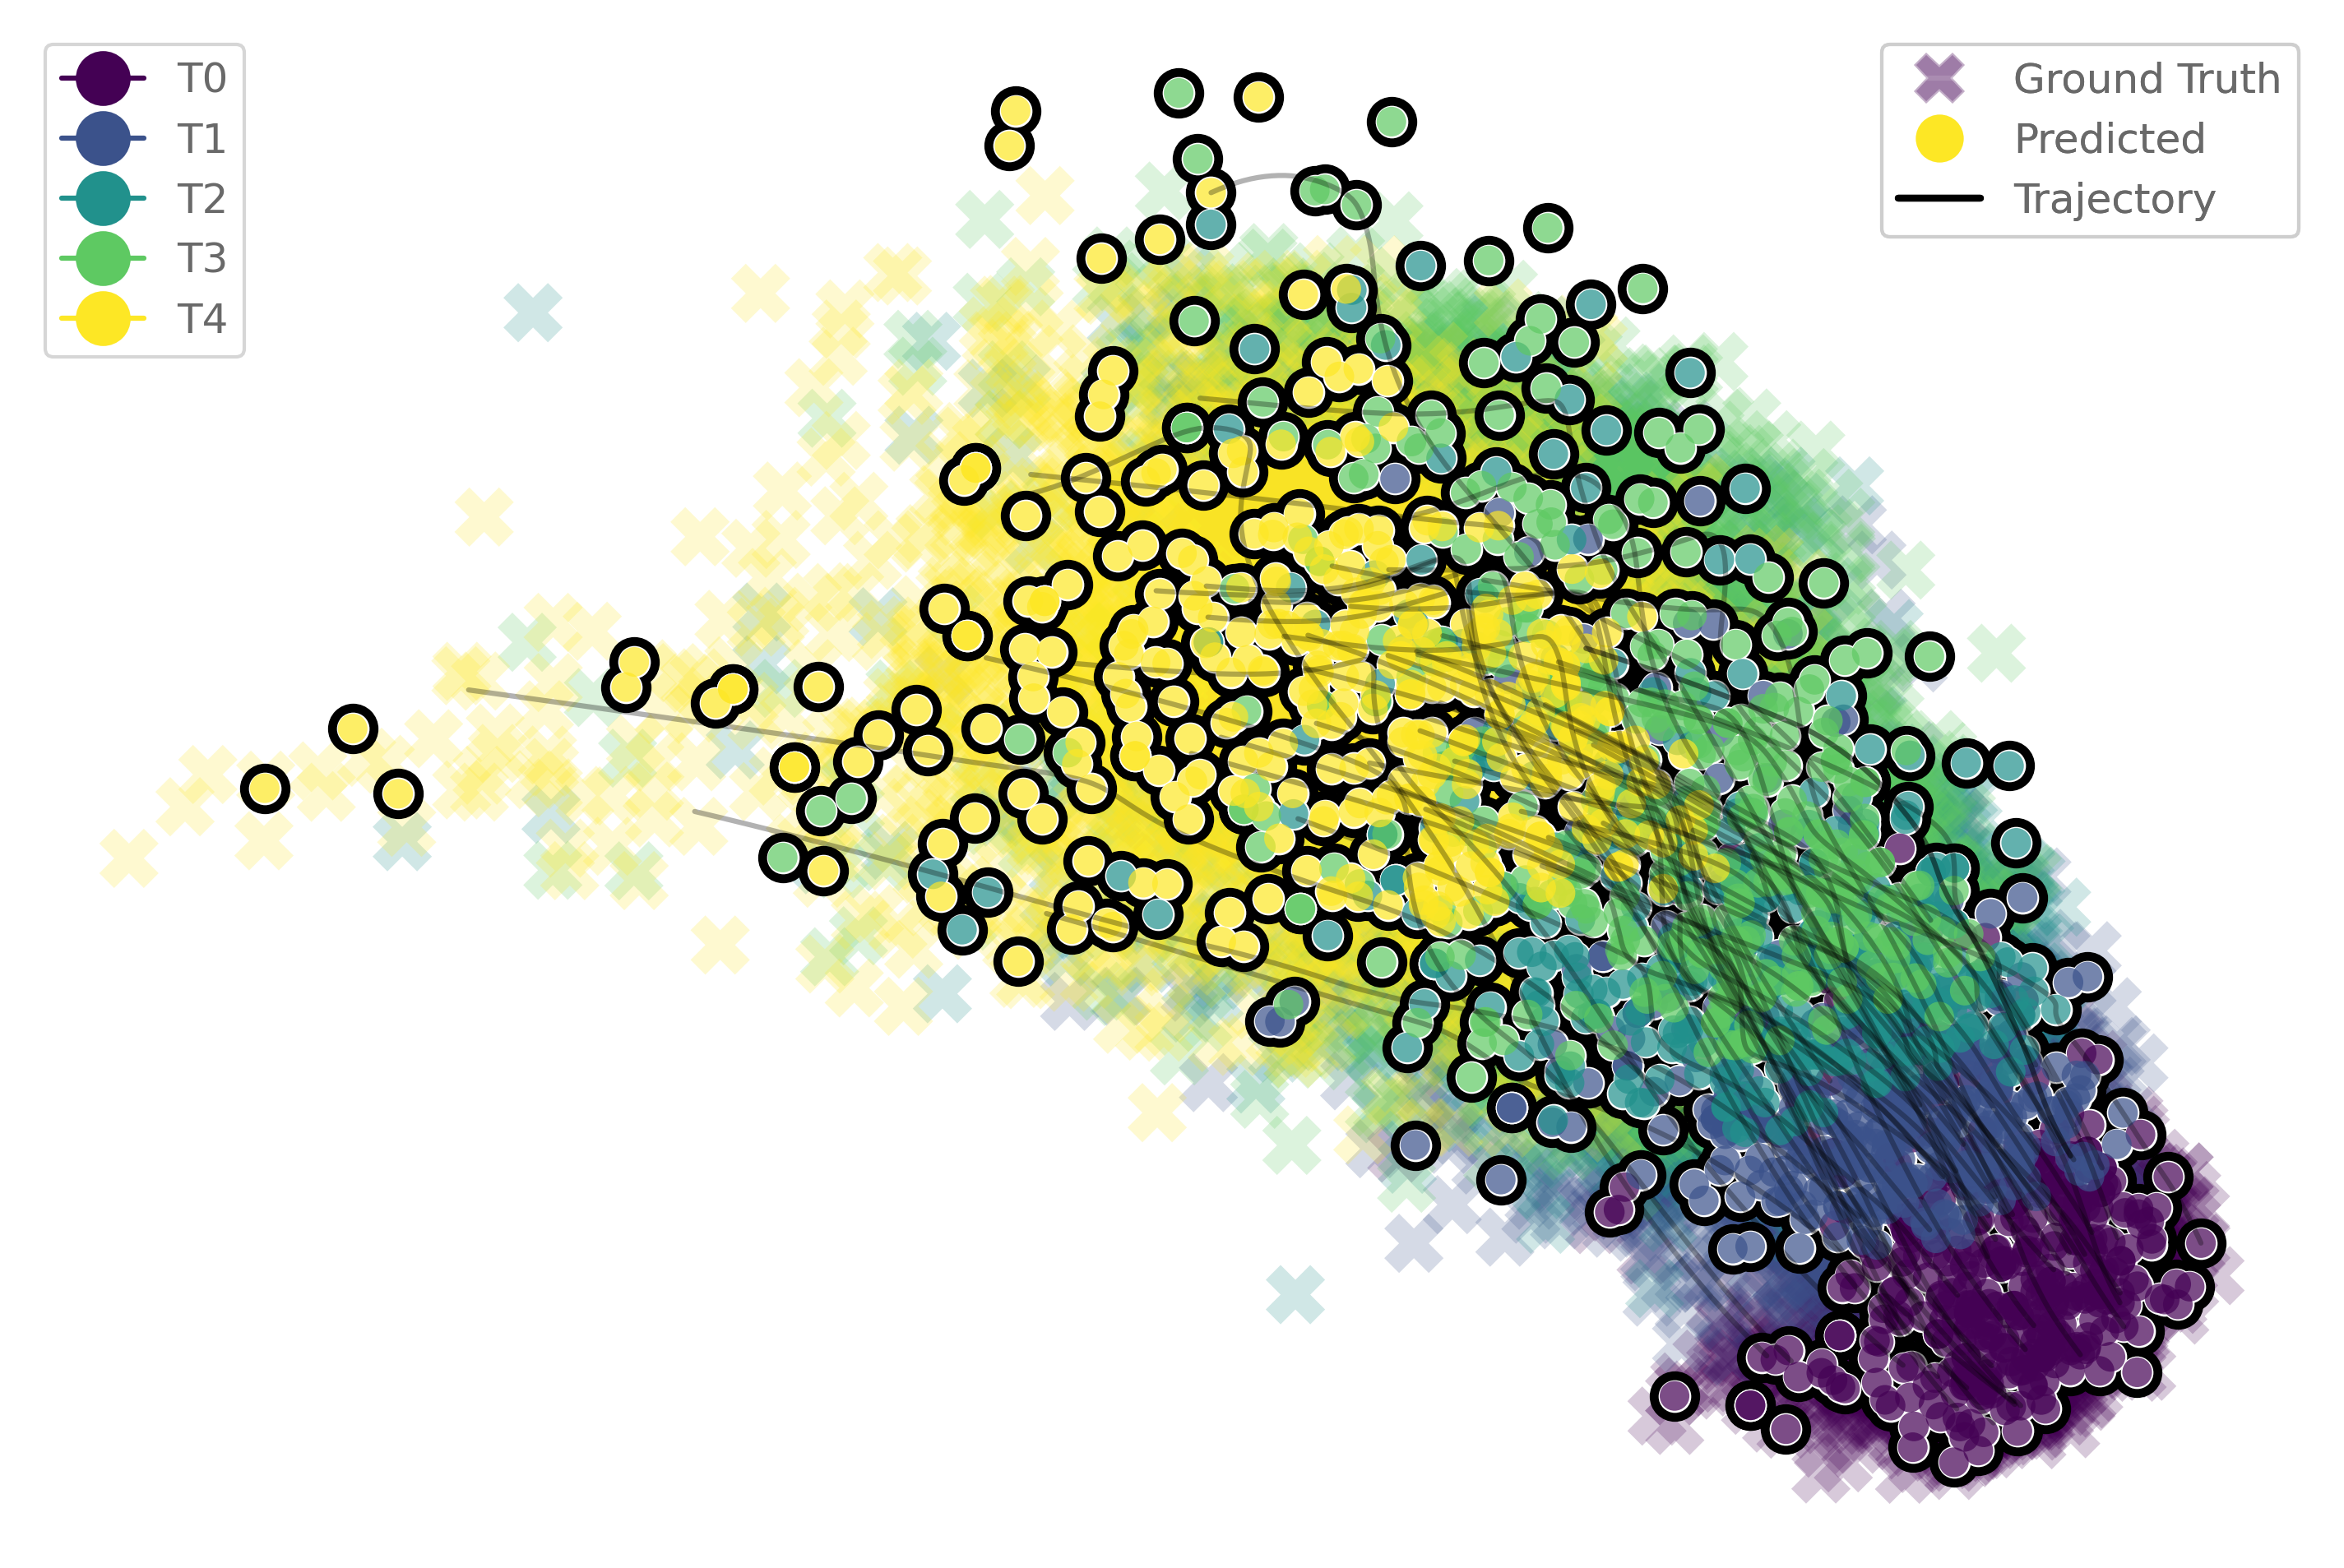

In [39]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_final.png',
    x='x1', y='x2', is_3d=False
)